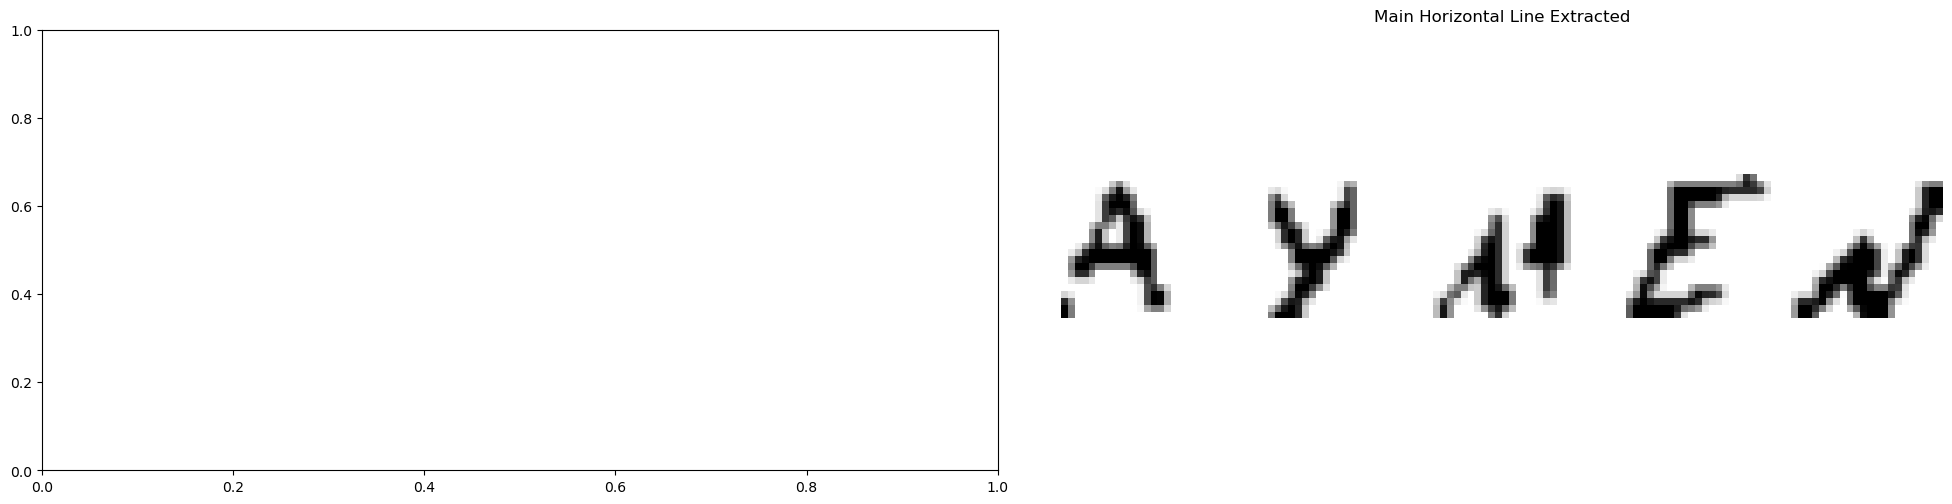

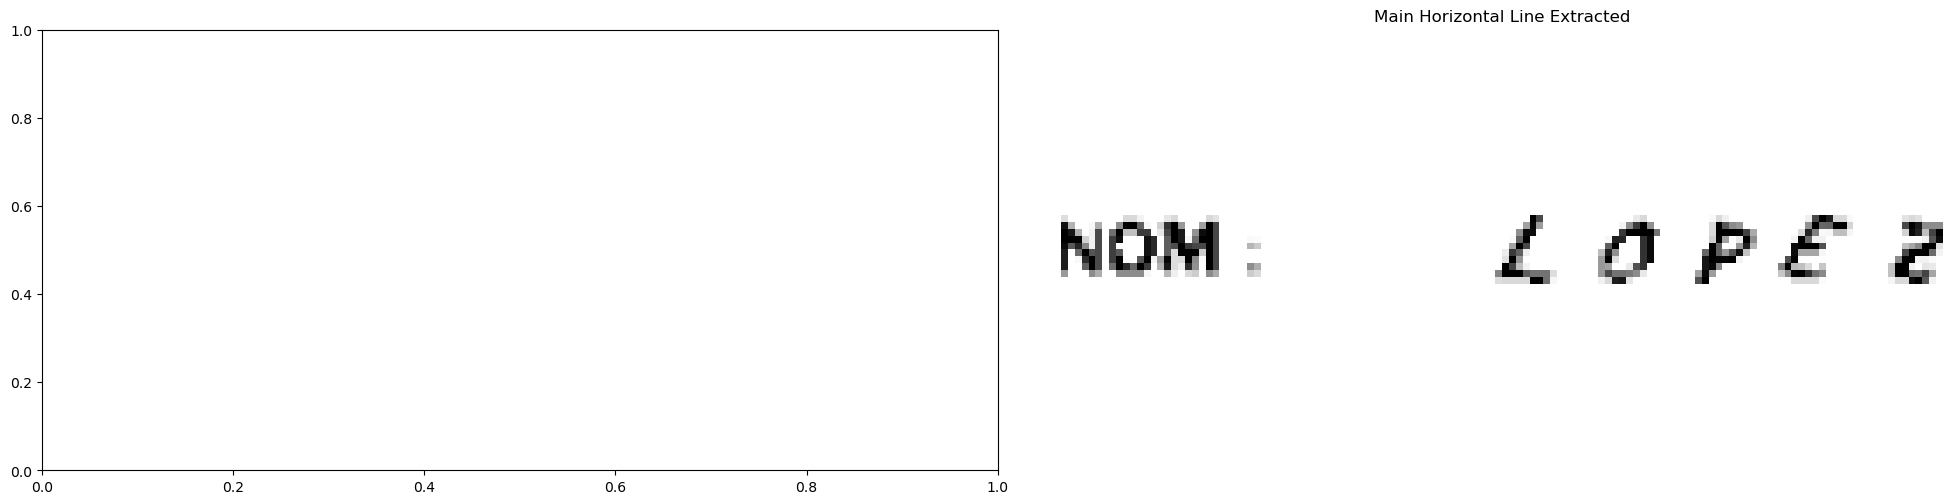

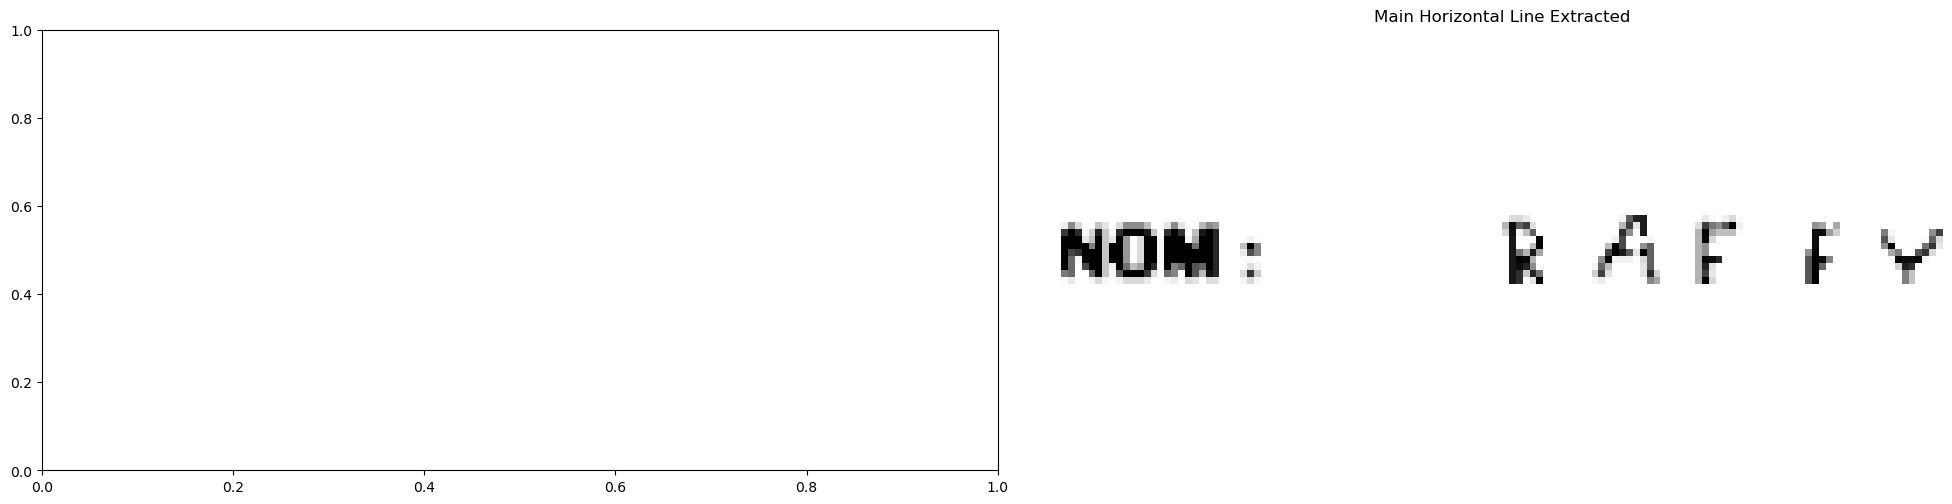

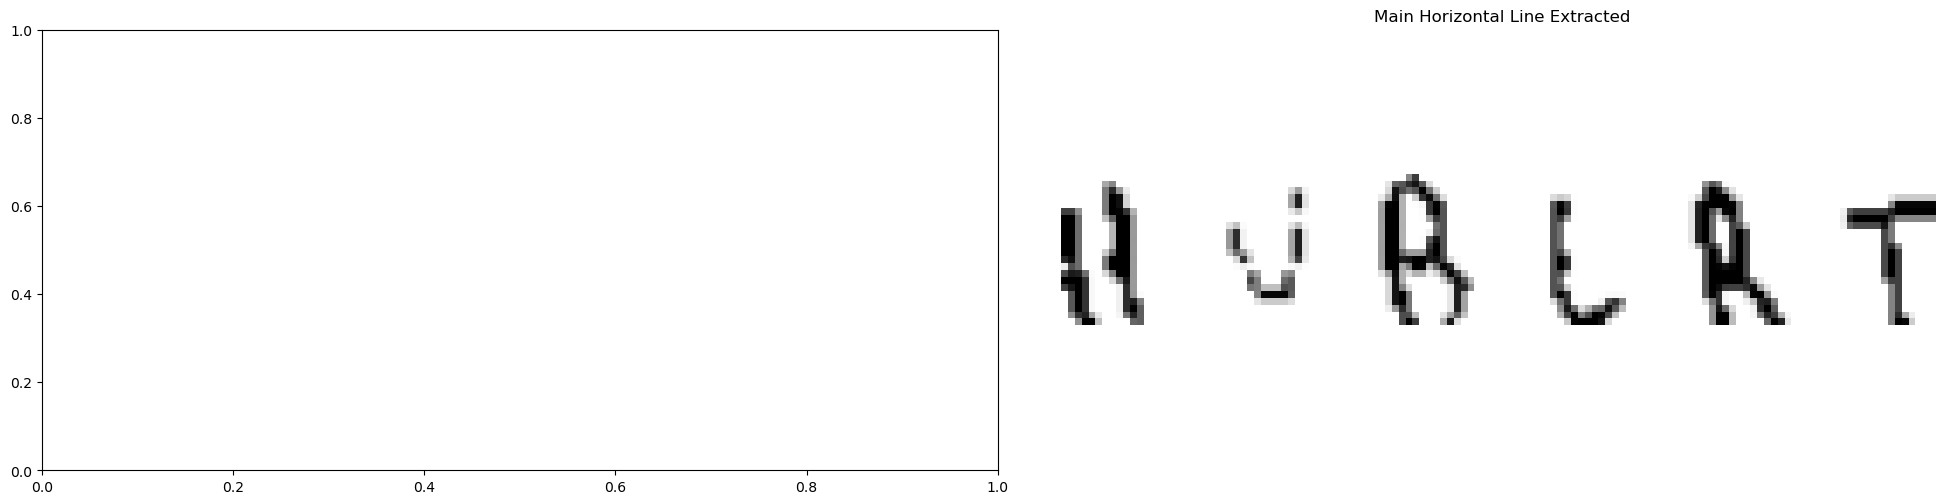

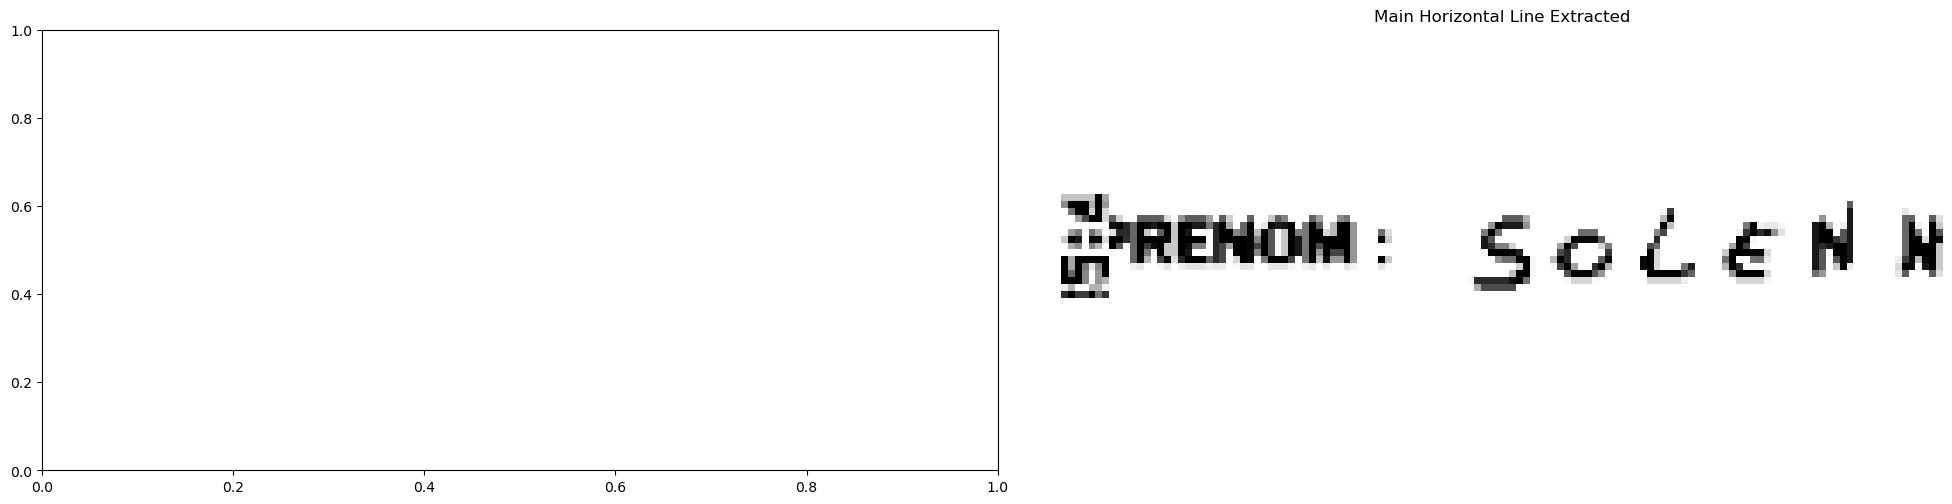

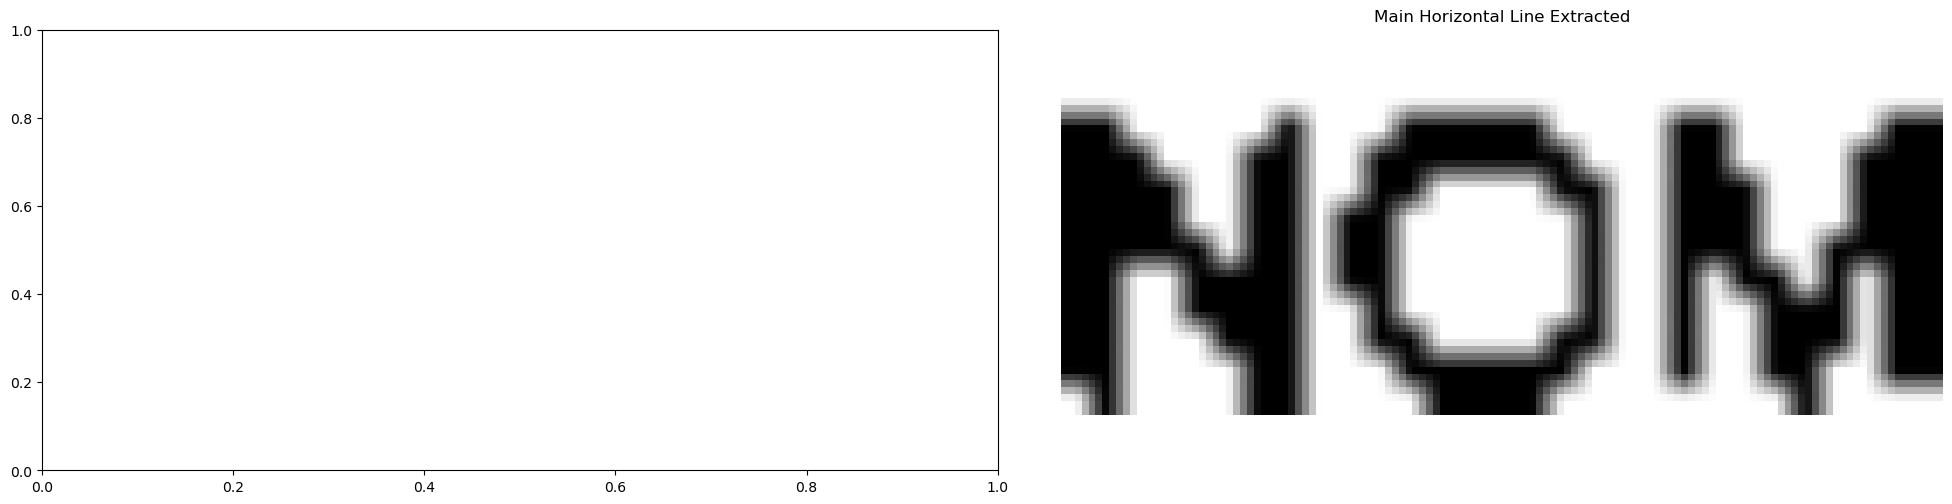

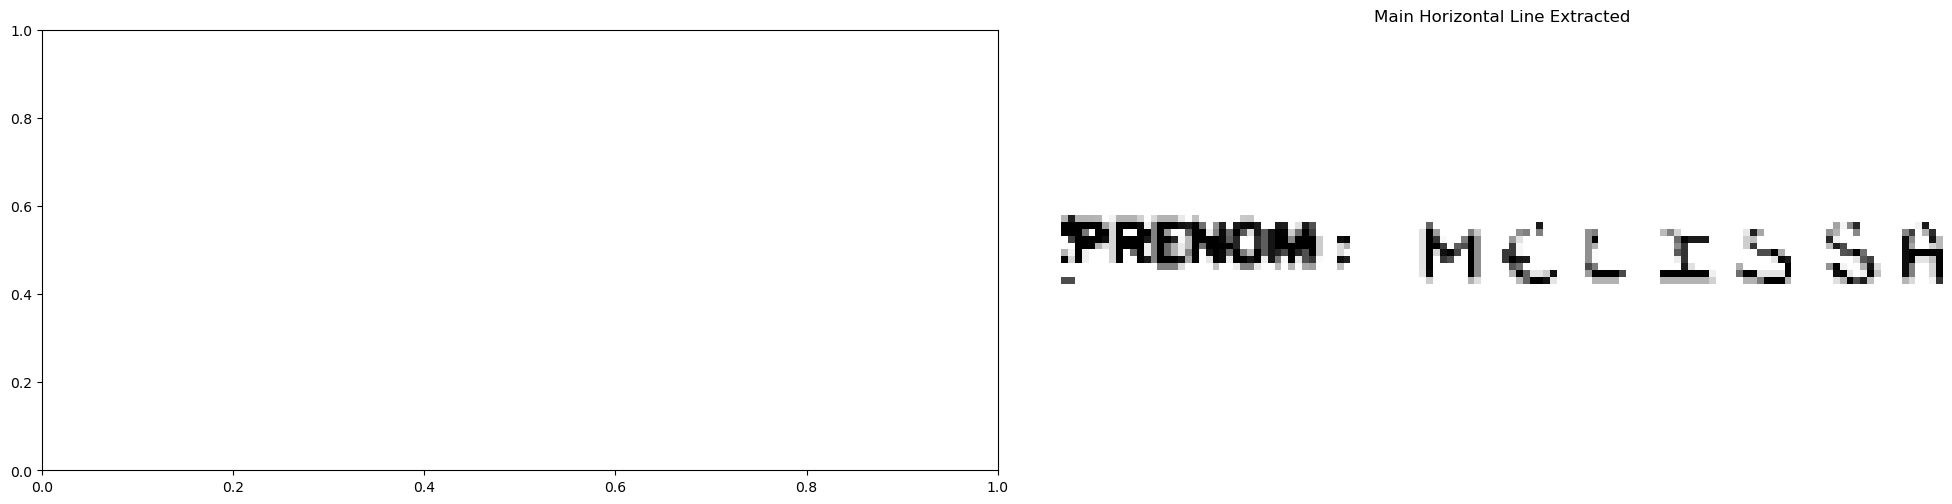

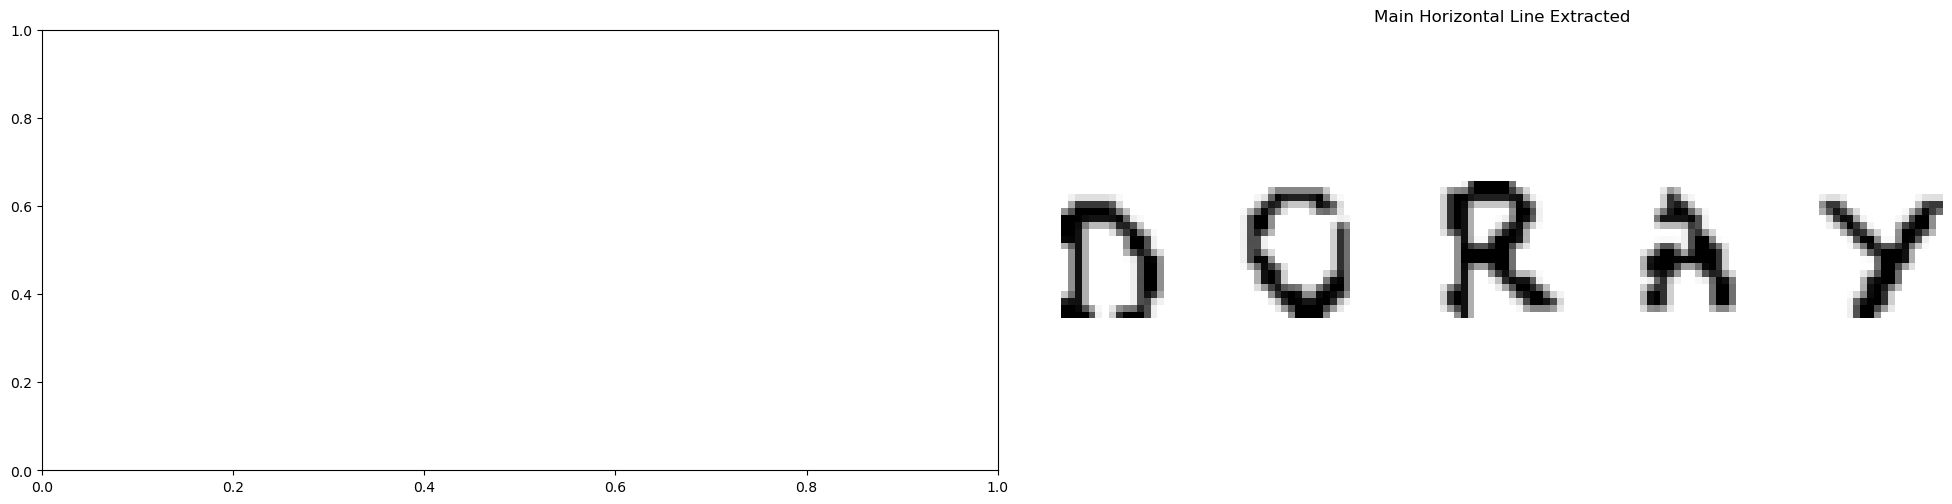

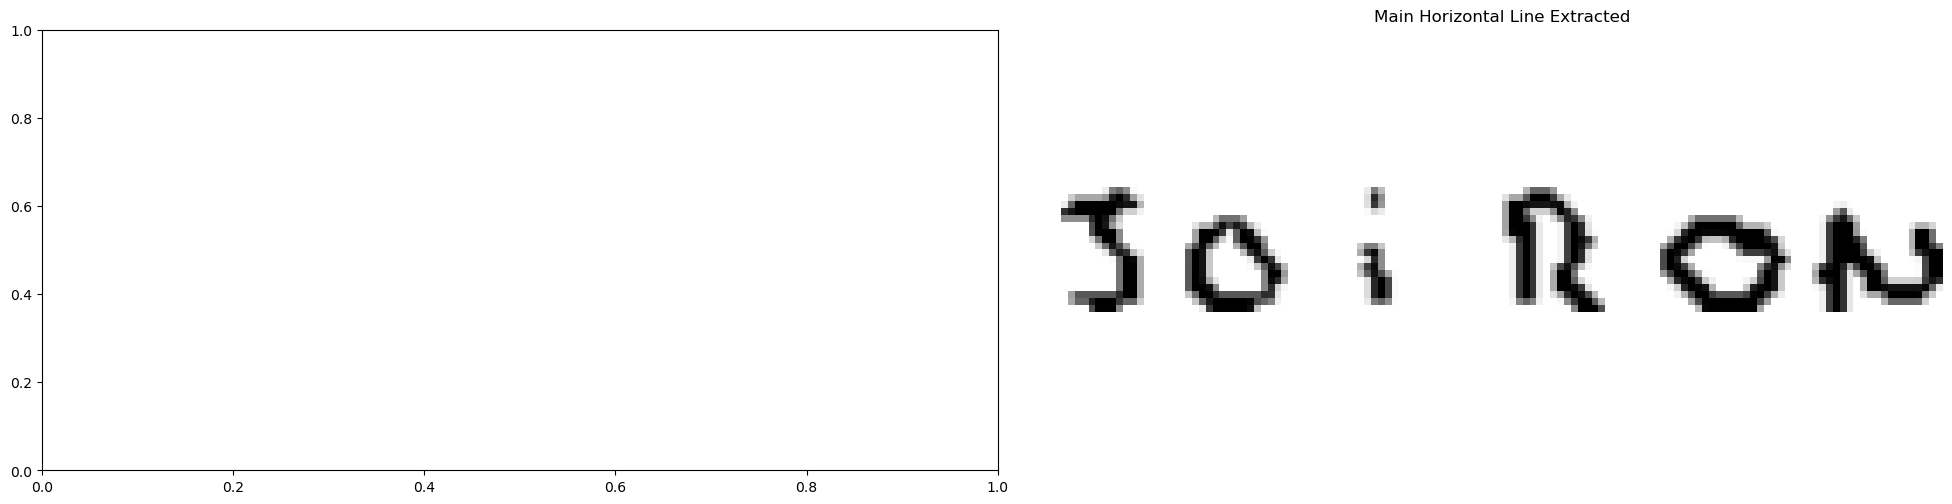

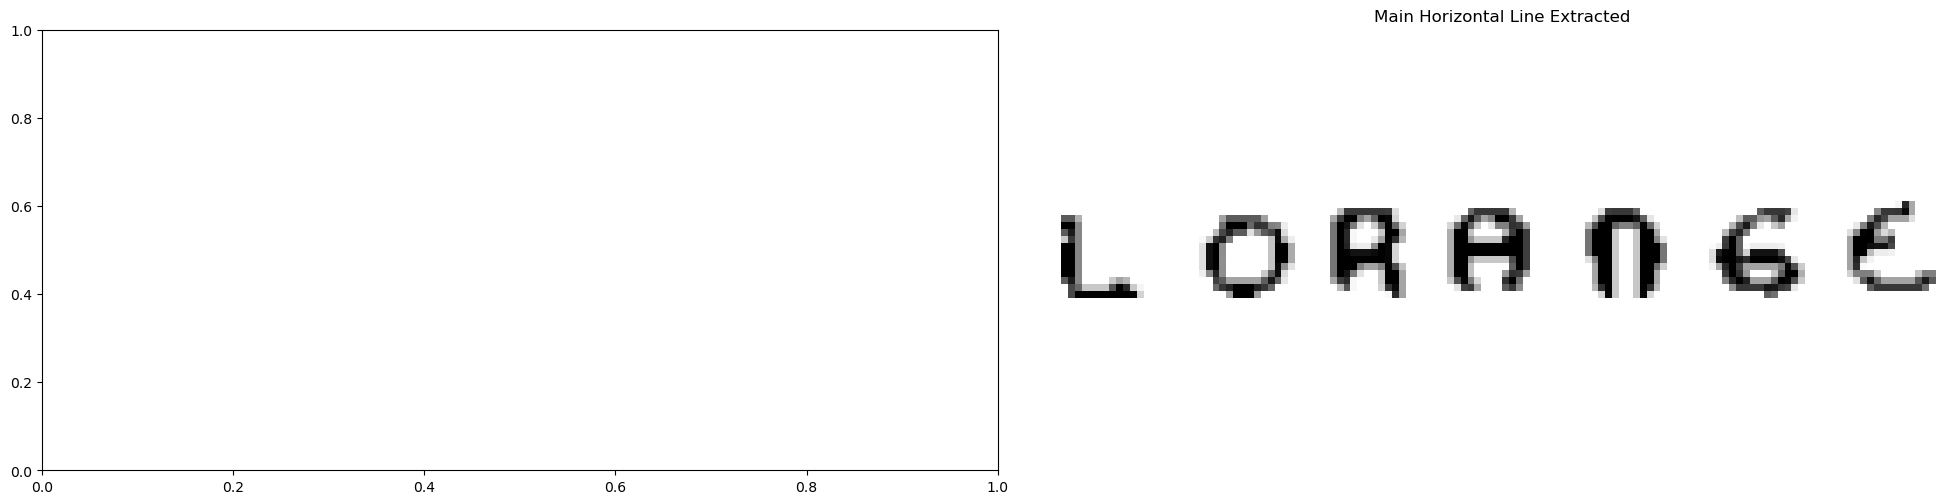

In [3]:
import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt

def increase_contrast(image, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8), blur_size=(2,2)):
    # Apply adaptive histogram equalization for contrast enhancement
    blur = cv2.blur(image,blur_size)
    # Create CLAHE object with specified parameters
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)
    
    # Apply CLAHE directly to grayscale image
    blur = clahe.apply(blur)
    return blur

def binarize_image(image):
    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def find_dividers(image, row_threshold_factor=0.04):
    # Sum pixels along the horizontal axis (rows)
    horizontal_sum = np.sum(image == 0, axis=1)
    
    # Set a threshold to detect empty (or near-empty) rows
    row_threshold = image.shape[1] * row_threshold_factor  # Adjust threshold based on image width
    dividers = [i for i, count in enumerate(horizontal_sum) if count < row_threshold]

    return dividers


def extract_main_line(image, dividers_in, width_weight=0.6, center_weight=0.4):
    # Identify the widest line or the middle line based on weighted criteria
    if not dividers_in:
        return image  # No dividers found, return the whole image
    
    dividers = [0]
    dividers.extend(dividers_in)
    dividers.append(image.shape[0])
    
    # Remove loner dividers
    dividers_nonloner = [dividers[i] for i in range(1, len(dividers) - 1) if dividers[i] - dividers[i - 1] == 1 or dividers[i + 1] - dividers[i] == 1]

    dividers = [0]
    dividers.extend(dividers_nonloner)
    dividers.append(image.shape[0])

    line_boundaries = [(dividers[i], dividers[i + 1]) for i in range(len(dividers) - 1)]
    line_widths = [(end - start, start, end) for start, end in line_boundaries]

    # Find the widest line
    widest_line = max(line_widths, key=lambda x: x[0])

    # Find the line closest to the center
    image_center = (image.shape[0]+1) // 2
    center_line = min(line_widths, key=lambda x: abs((x[1] + x[2]) // 2 - image_center))

    # Weighted combination (adjust weights as needed)
    chosen_line = max(
        [widest_line, center_line],
        key=lambda x: x[0] * width_weight - abs((x[1] + x[2]) // 2 - image_center) * center_weight
    )

    return image[chosen_line[1]:chosen_line[2], :]

def crop_white_space(image):
    # Find the first and last columns that are not entirely white (non-background pixels)
    non_white_cols = np.where(image != 255)[1]  # Non-white pixel columns

    if non_white_cols.size == 0:
        # If no non-white pixels found, return the original image
        return image

    # Get the leftmost and rightmost non-white columns
    left = non_white_cols.min()
    right = non_white_cols.max()

    # Crop the image to remove the extra white space
    cropped_image = image[:, left:right+1]

    return cropped_image

def resize_with_padding(image, target_width, target_height):
    # Get current dimensions
    h, w = image.shape

    # Handle empty images
    if w == 0 or h == 0:
        return np.full((target_height, target_width), 255, dtype=np.uint8)

    # Calculate scaling factor to maintain aspect ratio
    scale = min(target_width/w, target_height/h)
    
    # Calculate new dimensions, ensure at least 1 pixel
    new_w = max(1, int(w * scale))
    new_h = max(1, int(h * scale))
    
    # Resize image
    resized = cv2.resize(image, (new_w, new_h))
    
    # Create white padding
    padded = np.full((target_height, target_width), 255, dtype=np.uint8)
    
    # Calculate padding offsets
    x_offset = (target_width - new_w) // 2
    y_offset = (target_height - new_h) // 2
    
    # Place resized image in center of padded image
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return padded

def preview_directory(directory_path, image_list=None, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8), blur_size=(2,2), row_threshold_factor=0.02, width_weight=0.6, center_weight=0.4, target_width=128, target_height=64):
    # List all image files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select 10 random images from the directory
    selected_images = random.sample(image_files, min(10, len(image_files)))

    if image_list:
        selected_images = image_list

    for image_name in selected_images:
        image_path = os.path.join(directory_path, image_name)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Increase contrast
        contrast_image = increase_contrast(image, clahe_clip_limit, clahe_tile_grid_size, blur_size)

        # Binarize the image
        binary_image = binarize_image(contrast_image)
        dividers_h = find_dividers(binary_image, row_threshold_factor)

        # Extract the main horizontal line
        main_line_image = extract_main_line(binary_image, dividers_h, width_weight, center_weight)
        main_line_image = crop_white_space(main_line_image)
        main_line_image = resize_with_padding(main_line_image, target_width, target_height) # Add resizing step
        
        # Display all figures in one set
        fig, axs = plt.subplots(1, 2, figsize=(20, 5))  # Adjusted to include binary_graph

        axs[0].imshow(main_line_image, cmap='gray')
        axs[0].set_title(f'Main Horizontal Line Extracted')
        axs[0].axis('off')

        axs[1].imshow(main_line_image, cmap='gray')
        axs[1].set_title(f'Main Horizontal Line Extracted')
        axs[1].axis('off')


        plt.tight_layout()
        plt.show()

# Example usage
directory_path = 'validation_v2/validation'  # Replace with the path to your image directory
images_list = None
preview_directory(directory_path, image_list=images_list)

In [1]:
class ImagePreprocessor:
    def __init__(self) -> None:
        pass

    def process_directory(self, directory_path, output_directory_path, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8), blur_size=(2,2), row_threshold_factor=0.02, width_weight=0.6, center_weight=0.4, target_width=128, target_height=64, skip=True, skip_threshold=5):
        # List all image files in the directory
        image_files = [f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Select 10 random images from the directory
        # selected_images = random.sample(image_files, min(10, len(image_files)))
        selected_images = image_files
        bad_images = []

        # Generate string with preprocessing parameters
        param_string = f"_cl{clahe_clip_limit}_tg{clahe_tile_grid_size[0]}x{clahe_tile_grid_size[1]}_bl{blur_size[0]}x{blur_size[1]}_rt{row_threshold_factor}_ww{width_weight}_cw{center_weight}"
        output_directory_path = output_directory_path + param_string

        # Skip processing if output directory already exists
        if os.path.exists(output_directory_path):
            print(f"Output directory {output_directory_path} already exists. Skipping processing.")
            return []            
        
        # Create output directory if it doesn't exist
        os.makedirs(output_directory_path, exist_ok=True)

        for image_name in selected_images:
            image_path = os.path.join(directory_path, image_name)
            out_path = os.path.join(output_directory_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            contrast_image = increase_contrast(image, clahe_clip_limit, clahe_tile_grid_size, blur_size)

            binary_image = binarize_image(contrast_image)
            dividers_h = find_dividers(binary_image, row_threshold_factor)

            # Extract the main horizontal line
            main_line_image = extract_main_line(binary_image, dividers_h, width_weight, center_weight)
            main_line_image = crop_white_space(main_line_image)
            main_line_image = resize_with_padding(main_line_image, target_width, target_height) # Add resizing step

            if skip and main_line_image.shape[0] < skip_threshold:
                bad_images.append(image_name)
            else:
                cv2.imwrite(out_path, main_line_image)
        
        # print(len(bad_images), "out of", len(selected_images) ,"were bad!")
        return bad_images
    
    def process_directory_and_load(self, directory_path, output_directory_path, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8), blur_size=(2,2), row_threshold_factor=0.02, width_weight=0.6, center_weight=0.4, target_width=128, target_height=64, skip=True, skip_threshold=5):
        # List all image files in the directory
        image_files = [f for f in os.listdir(directory_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Select 10 random images from the directory
        # selected_images = random.sample(image_files, min(10, len(image_files)))
        selected_images = image_files
        bad_images = []
        image_data = []

        # Generate string with preprocessing parameters
        param_string = f"_cl{clahe_clip_limit}_tg{clahe_tile_grid_size[0]}x{clahe_tile_grid_size[1]}_bl{blur_size[0]}x{blur_size[1]}_rt{row_threshold_factor}_ww{width_weight}_cw{center_weight}"
        output_directory_path = output_directory_path + param_string

        # Skip processing if output directory already exists
        if os.path.exists(output_directory_path):
            print(f"Output directory {output_directory_path} already exists. Skipping processing.")
            for image_name in selected_images:
                out_path = os.path.join(output_directory_path, image_name)
                image = cv2.imread(out_path, cv2.IMREAD_GRAYSCALE)

                if skip and main_line_image.shape[0] < skip_threshold:
                    bad_images.append(image_name)
                else:
                    image_data.append(image)
            return image_data
        
        # Create output directory if it doesn't exist
        os.makedirs(output_directory_path, exist_ok=True)

        for image_name in selected_images:
            image_path = os.path.join(directory_path, image_name)
            out_path = os.path.join(output_directory_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            contrast_image = increase_contrast(image, clahe_clip_limit, clahe_tile_grid_size, blur_size)

            binary_image = binarize_image(contrast_image)
            dividers_h = find_dividers(binary_image, row_threshold_factor)

            # Extract the main horizontal line
            main_line_image = extract_main_line(binary_image, dividers_h, width_weight, center_weight)
            main_line_image = crop_white_space(main_line_image)
            main_line_image = resize_with_padding(main_line_image, target_width, target_height) # Add resizing step

            if skip and main_line_image.shape[0] < skip_threshold:
                bad_images.append(image_name)
            else:
                image_data.append(main_line_image)
        
        # print(len(bad_images), "out of", len(selected_images) ,"were bad!")
        return image_data